# Proyek Klasifikasi Ras Anjing Menggunakan CNN dan Transfer Learning

Proyek ini bertujuan untuk mengklasifikasikan gambar anjing ke dalam beberapa ras menggunakan model deep learning dengan pendekatan transfer learning (MobileNetV2).



##Data Preparation

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mitamukaromah","key":"2676184a009d81cec4c61f3800d11b6b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d yapwh1208/dogs-breed-dataset
!unzip -q dogs-breed-dataset.zip -d /content/dog_breed_dataset

Dataset URL: https://www.kaggle.com/datasets/yapwh1208/dogs-breed-dataset
License(s): CC-BY-NC-SA-4.0
 97% 608M/629M [00:01<00:00, 293MB/s]
100% 629M/629M [00:01<00:00, 386MB/s]


## Import Semua Packages/Library yang Digunakan

In [109]:
#  Library umum
import numpy as np
import pandas as pd
import os, shutil, pathlib, random

#  Visualisasi & Statistik
import matplotlib.pyplot as plt
import seaborn as sn

#  Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#  Image processing
from PIL import Image
import cv2
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte

#  Data handling
import splitfolders
import tqdm

#  TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers, optimizers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input

## Exploratory Data Analysis (EDA)

In [110]:
# Menentukan direktori dataset
data_dir = '/content/dog_breed_dataset'

In [111]:
# Menghitung jumlah kelas berdasarkan folder dalam direktori
classes = []

for file in os.listdir(data_dir):
    classes.append(file)

print(f"Jumlah kelas berjumlah {len(classes)}, yaitu:")
print(classes)

# Simpan ke variabel
JUMLAH_CLASS = len(classes)

Jumlah kelas berjumlah 1, yaitu:
['dog_v1']


In [112]:
# Definisikan path dataset
dog_path = '/content/dog_breed_dataset'

# Siapkan list kosong
file_name = []
labels = []
full_path = []

# Loop untuk isi list
for path, subdirs, files in os.walk(dog_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Buat DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

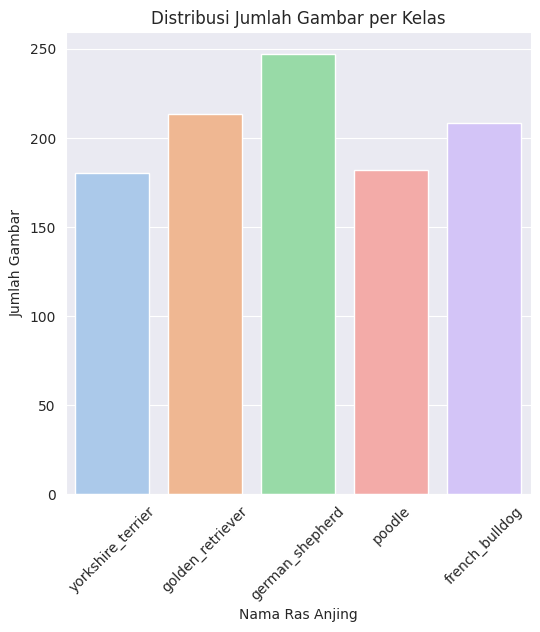

In [113]:
df_label = pd.DataFrame({'label': distribution_train['labels']})

# Visualisasi distribusi label
plt.figure(figsize=(6, 6))
sn.set_style("darkgrid")
plot_data = sn.countplot(data=df_label, x="label", hue="label", palette="pastel", legend=False)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Nama Ras Anjing")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

Visualisasi Sampel Gambar per Kelas

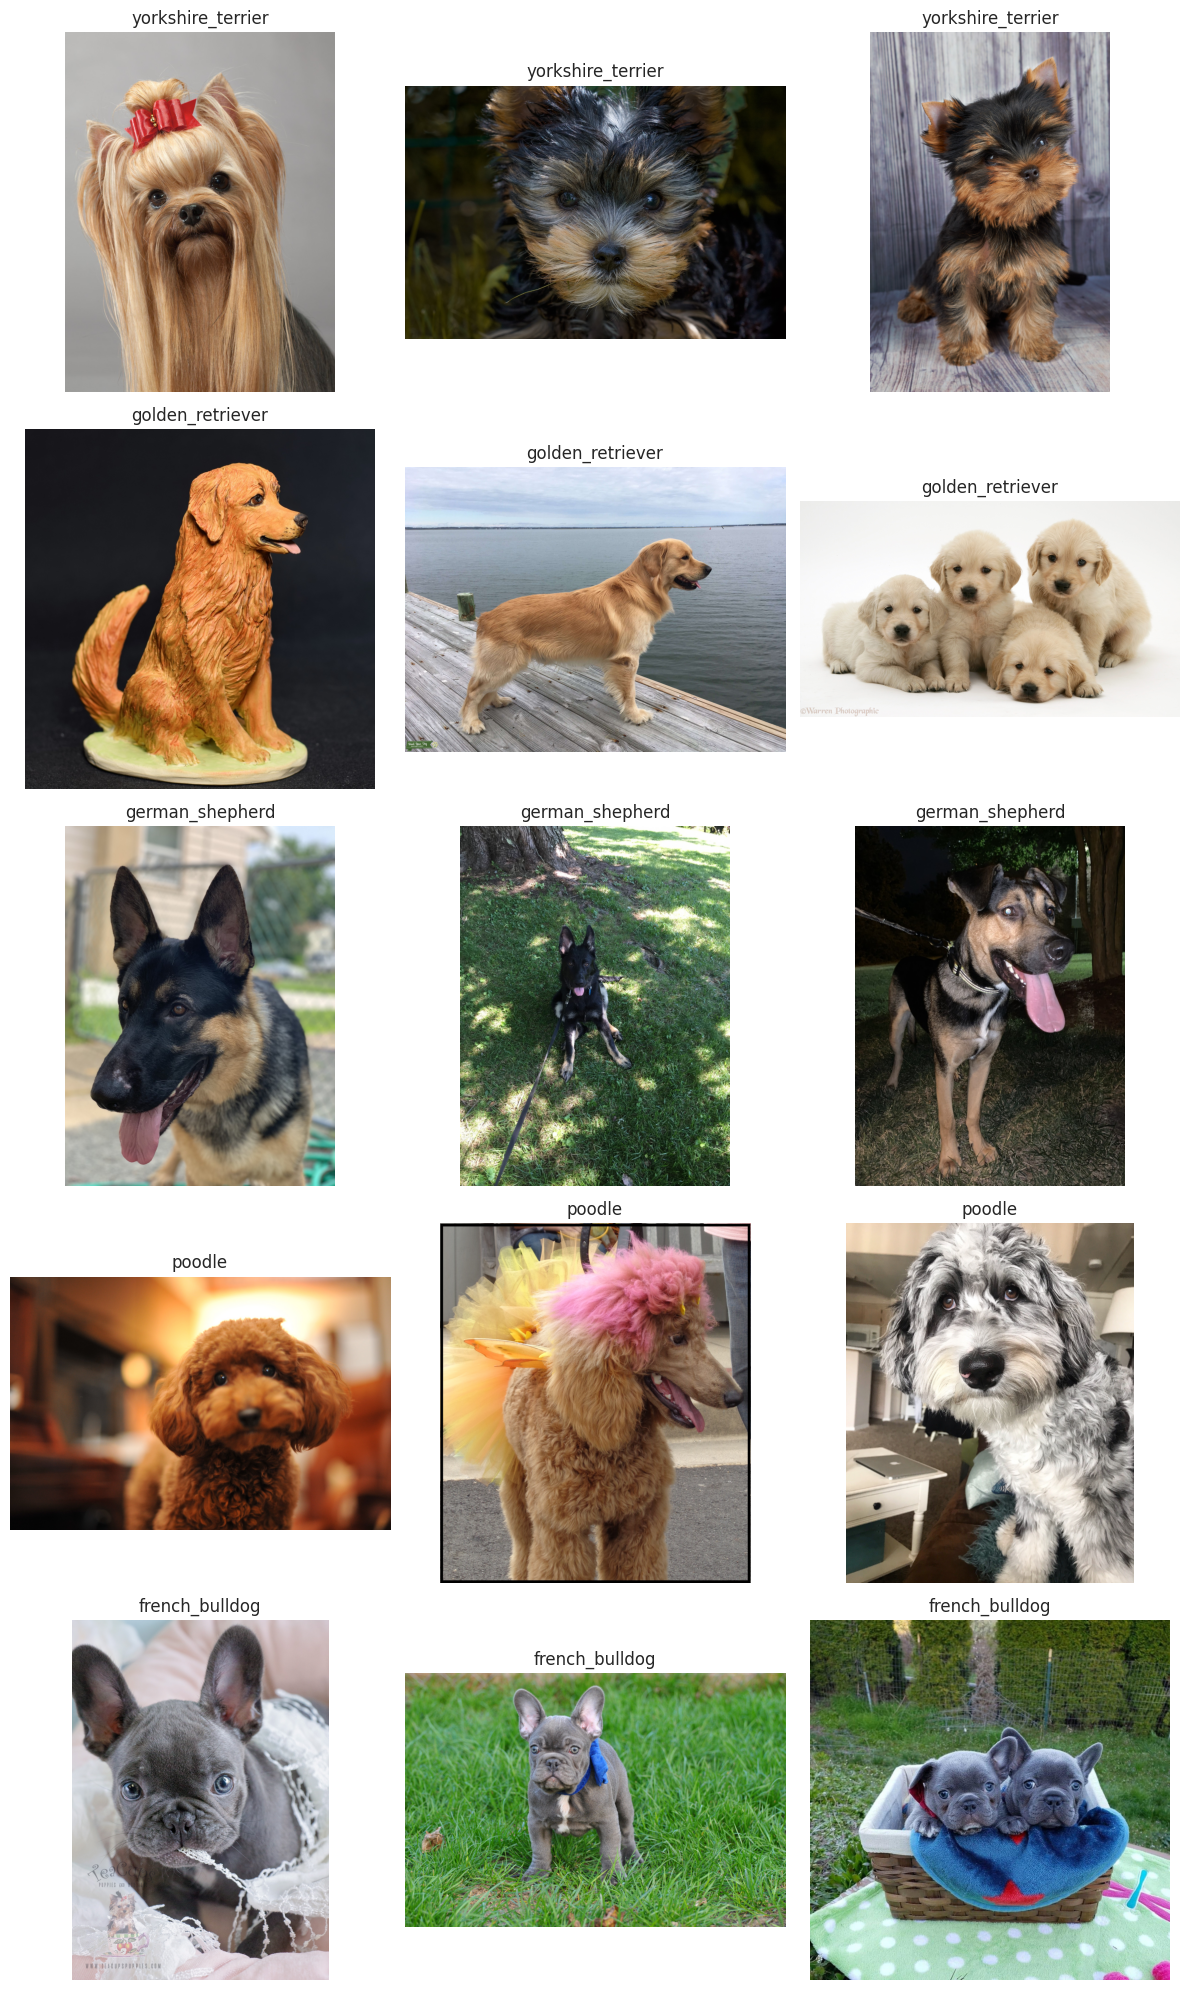

In [114]:
# Membuat kamus yang menyimpan daftar gambar untuk setiap kelas
cat_image = {}
path = '/content/dog_breed_dataset/dog_v1'

# Pastikan hanya ambil folder yang valid
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Ambil hanya file gambar (opsional: bisa tambahkan ekstensi spesifik)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:  # Pastikan tidak kosong
            cat_image[class_name] = image_files

# Menampilkan 3 gambar acak dari setiap kelas
num_class = len(cat_image.keys())
fig, axs = plt.subplots(num_class, 3, figsize=(12, 4 * num_class))

# Jika hanya 1 kelas, axs jadi 1D, ubah jadi 2D agar konsisten
if num_class == 1:
    axs = np.expand_dims(axs, axis=0)

for i, class_name in enumerate(cat_image.keys()):
    images = np.random.choice(cat_image[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert('RGB')
        axs[i, j].imshow(img)
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

fig.tight_layout()
plt.show()

Split Dataset

In [115]:
# Direktori asal
input_folder = '/content/dog_breed_dataset/dog_v1'  # ini folder asli dengan struktur subfolder per kelas

# Direktori tujuan
output_folder = '/content/dog_split'  # folder hasil split

# Split data: 80% train, 10% val, 10% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 1030 files [00:02, 452.52 files/s]


Load Dataset dengan image_dataset_from_directory

In [116]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dog_split/train',
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dog_split/val',
    image_size=(224, 224),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/dog_split/test',
    image_size=(224, 224),
    batch_size=32
)

class_names = train_ds.class_names
print(f"Daftar kelas: {class_names}")

Found 822 files belonging to 5 classes.
Found 101 files belonging to 5 classes.
Found 107 files belonging to 5 classes.
Daftar kelas: ['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


In [117]:
rescale = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (rescale(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (rescale(x), y)).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (rescale(x), y)).prefetch(tf.data.AUTOTUNE)

## Data Preprocessing

Real-Time Augmentation

In [118]:
# Parameter
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi
    rotation_range=30,           # Rotasi acak maksimal 30 derajat
    width_shift_range=0.2,       # Pergeseran horizontal (20%)
    height_shift_range=0.2,      # Pergeseran vertikal (20%)
    shear_range=0.2,             # Shear acak
    zoom_range=0.2,              # Zoom in/out
    horizontal_flip=True,        # Flip horizontal
    fill_mode='nearest'          # Isi piksel kosong
)

# Untuk validasi dan test, hanya lakukan normalisasi (tanpa augmentasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [119]:
# Ambil data dari folder split
train_dir = '/content/dog_split/train'
val_dir   = '/content/dog_split/val'
test_dir  = '/content/dog_split/test'

# Load data dengan augmentasi real-time
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validasi dan test generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 822 images belonging to 5 classes.
Found 101 images belonging to 5 classes.
Found 107 images belonging to 5 classes.


In [120]:
# Cek Daftar Kelas
class_names = list(train_generator.class_indices.keys())
print("Daftar kelas:", class_names)

Daftar kelas: ['french_bulldog', 'german_shepherd', 'golden_retriever', 'poodle', 'yorkshire_terrier']


Callback untuk Visualisasi

In [121]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

Lihat contoh batch hasil augmentasi (debugging visual)

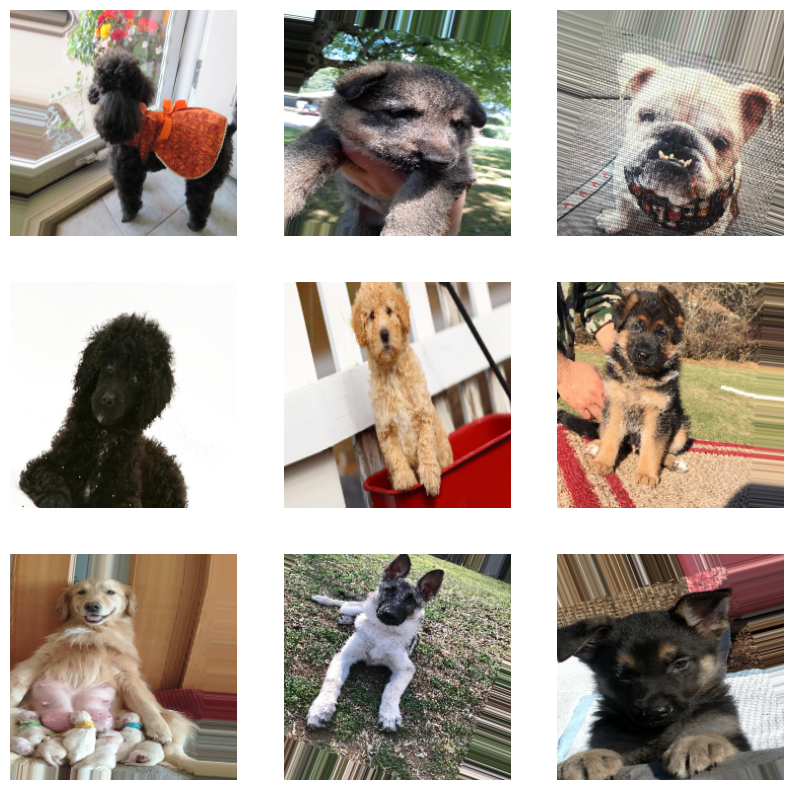

In [122]:
images, labels = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

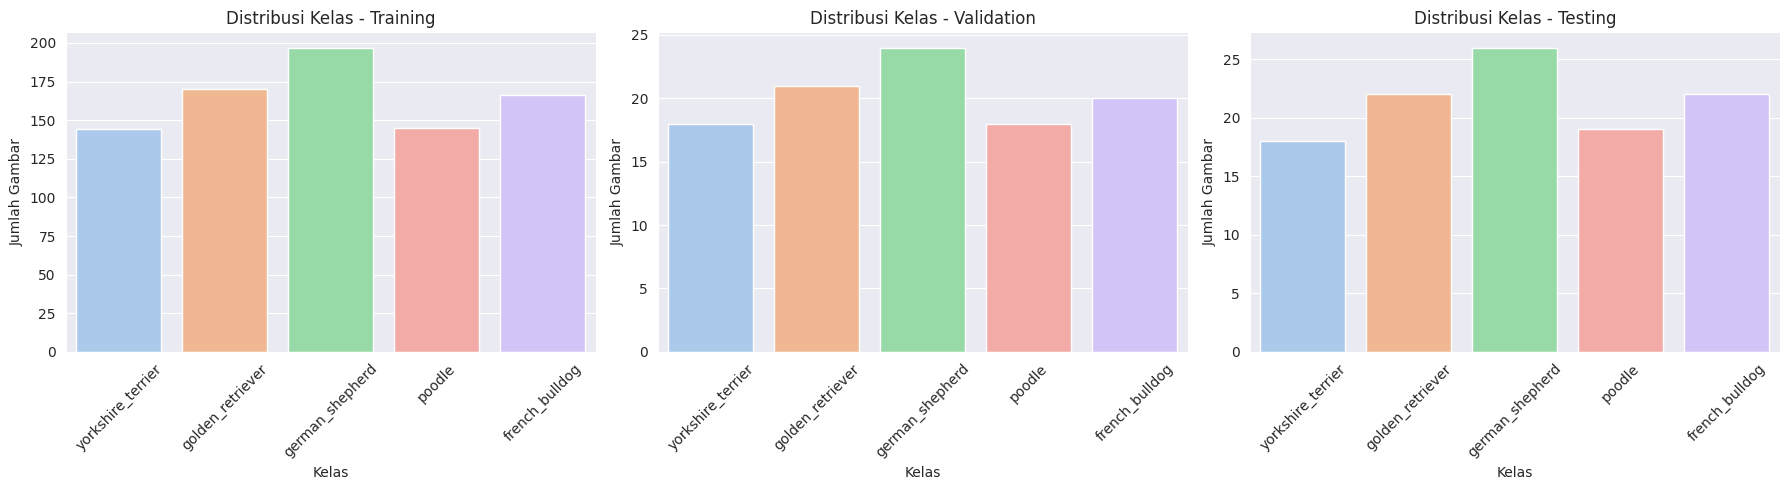

In [123]:
# Fungsi untuk membuat DataFrame distribusi label dari direktori
def get_distribution_from_folder(folder_path):
    labels = []
    file_names = []
    full_paths = []

    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if os.path.isdir(label_folder):
            for fname in os.listdir(label_folder):
                fpath = os.path.join(label_folder, fname)
                full_paths.append(fpath)
                file_names.append(fname)
                labels.append(label)

    return pd.DataFrame({
        "path": full_paths,
        "file_name": file_names,
        "labels": labels
    })

# Path ke masing-masing folder hasil split
train_path = '/content/dog_split/train'
val_path = '/content/dog_split/val'
test_path = '/content/dog_split/test'

# Buat DataFrame untuk masing-masing set
df_train = get_distribution_from_folder(train_path)
df_val   = get_distribution_from_folder(val_path)
df_test  = get_distribution_from_folder(test_path)

# Plot ketiga distribusi
plt.figure(figsize=(18, 5))

# Training
plt.subplot(1, 3, 1)
sn.countplot(data=df_train, x="labels", hue="labels", palette="pastel", legend=False)
plt.title("Distribusi Kelas - Training")
plt.xticks(rotation=45)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")

# Validation
plt.subplot(1, 3, 2)
sn.countplot(data=df_val, x="labels", hue="labels", palette="pastel", legend=False)
plt.title("Distribusi Kelas - Validation")
plt.xticks(rotation=45)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")

# Testing
plt.subplot(1, 3, 3)
sn.countplot(data=df_test, x="labels", hue="labels", palette="pastel", legend=False)
plt.title("Distribusi Kelas - Testing")
plt.xticks(rotation=45)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")

plt.tight_layout()
plt.show()

jumlah data pada masing-masing set

In [124]:
print("Jumlah data train:", train_generator.samples)
print("Jumlah data val:  ", val_generator.samples)
print("Jumlah data test: ", test_generator.samples)

print("Jumlah kelas:", train_generator.num_classes)
print("Ukuran batch:", train_generator.batch_size)
print("Label kelas:", train_generator.class_indices)

Jumlah data train: 822
Jumlah data val:   101
Jumlah data test:  107
Jumlah kelas: 5
Ukuran batch: 32
Label kelas: {'french_bulldog': 0, 'german_shepherd': 1, 'golden_retriever': 2, 'poodle': 3, 'yorkshire_terrier': 4}


## Model Architecture

In [125]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze base model (opsional)
base_model.trainable = False

# Tambahkan layer kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)

# Buat model final
model = Model(inputs=base_model.input, outputs=output_layer)

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_14[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [126]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [127]:
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    checkpoint
]

In [128]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6509 - loss: 0.9382

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6651 - loss: 0.9038 - val_accuracy: 0.9307 - val_loss: 0.1693 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9855 - loss: 0.0545 - val_accuracy: 0.9307 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9779 - loss: 0.0760 - val_accuracy: 0.9604 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9777 - loss: 0.0712 - val_accuracy: 0.9505 - val_loss: 0.1107 - learning_rate: 0.0010
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9869 - loss: 0.0457 - val_accuracy: 0.9505 - val_loss: 0.1076 - learning_rate: 0.0010
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9829 - loss: 0.0442 - val_accuracy: 0.9505 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9870 - loss: 0.0432 - val_accuracy: 0.9406 - va

In [129]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi data test: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9963 - loss: 0.0243
Akurasi data test: 0.99


## Evaluasi dan Visualisasi

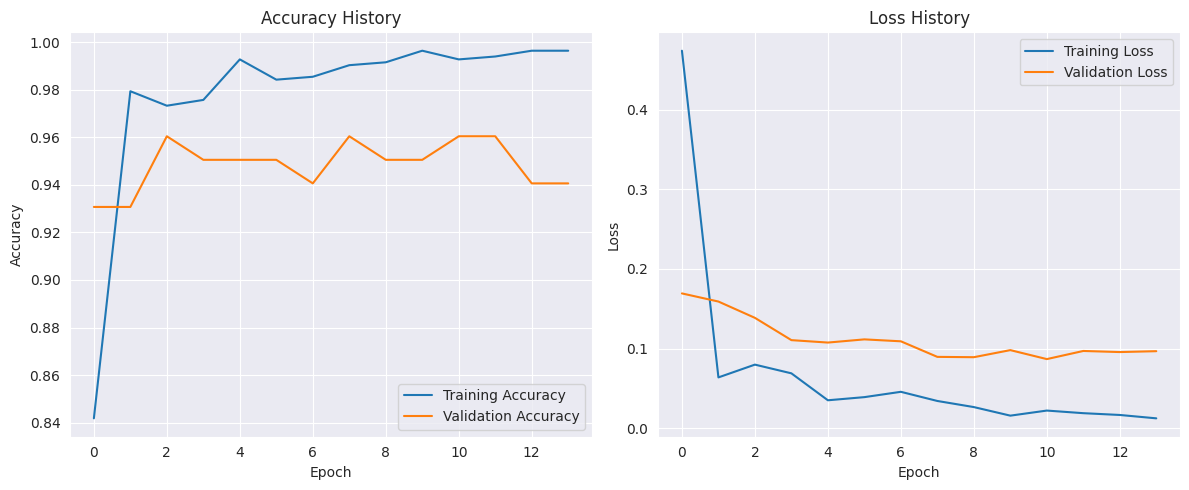

In [130]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [131]:
Y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
[[22  0  0  0  0]
 [ 0 26  0  0  0]
 [ 0  0 22  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  1 17]]
                   precision    recall  f1-score   support

   french_bulldog       1.00      1.00      1.00        22
  german_shepherd       1.00      1.00      1.00        26
 golden_retriever       1.00      1.00      1.00        22
           poodle       0.95      1.00      0.97        19
yorkshire_terrier       1.00      0.94      0.97        18

         accuracy                           0.99       107
        macro avg       0.99      0.99      0.99       107
     weighted avg       0.99      0.99      0.99       107



4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


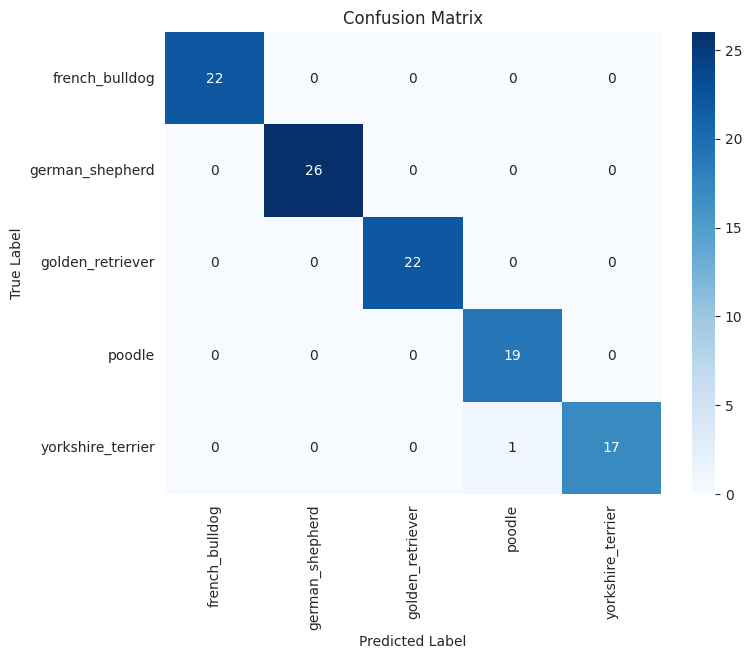

In [132]:
# Prediksi hasil dari test_generator
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Label asli dari test_generator
y_true = test_generator.classes

# Matriks kebingungan (confusion matrix)
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Menyimpan Model

In [133]:
model.save("dog_breed_classifier_final.keras")
model.save("dog_breed_classifier_final.h5")